In [ ]:
!pip install tensorflow-gpu==2.0.0-rc1

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
tf.__version__

'1.12.0'

## Plot Accuracy and Load Data

In [11]:
def plot_loss_history(histories, key='loss'):
  plt.figure(figsize=(8,5))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

In [12]:
def plot_accuracy_history(histories, key='accuracy'):
  plt.figure(figsize=(8,5))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

## Cifar 10

#### Load Data and Reshape

In [13]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# reshape
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [14]:
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (50000, 32, 32, 3)
Number of images in x_train 50000
Number of images in x_test 10000


#### One-hot Encoding, Normalize and Crop Data

In [15]:
# one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# normalize -1~1
x_train = (x_train-127.5)/127.5
x_test = (x_test-127.5)/127.5

# validation
x_val = x_train[-1000:]
y_val = y_train[-1000:]
x_train = x_train[:-1000]
y_train = y_train[:-1000]

#### Simple CNN and Comparing SGD with Adam

In [16]:
lrate = 5e-4
epochs = 15
decay = lrate/epochs
bsize = 32

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')    
])
model.summary()
optimizer = tf.keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
sgd_baseline_history = model.fit(x_train, y_train, epochs=epochs, batch_size=bsize, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__________

KeyboardInterrupt: 

In [18]:
lrate = 5e-4
epochs = 15
bsize = 32

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')    
])
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=lrate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
adam_baseline_history = model.fit(x_train, y_train, epochs=epochs, batch_size=bsize, validation_data=(x_val, y_val))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

#### Complex CNN and Comparing SGD with Adam

In [20]:
lrate = 5e-4
epochs = 15
decay = lrate/epochs
bsize = 32

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()
optimizer = tf.keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
sgd_deeper_history = model.fit(x_train, y_train, epochs=epochs, batch_size=bsize, validation_data=(x_val, y_val))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
average_pooling2d_3 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d_4 (Average (None, 8, 8, 64)         

In [22]:
lrate = 5e-4
epochs = 15
bsize = 32

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=lrate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
adam_deeper_history = model.fit(x_train, y_train, epochs=epochs, batch_size=bsize, validation_data=(x_val, y_val))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
average_pooling2d_9 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d_10 (Averag (None, 8, 8, 64)         

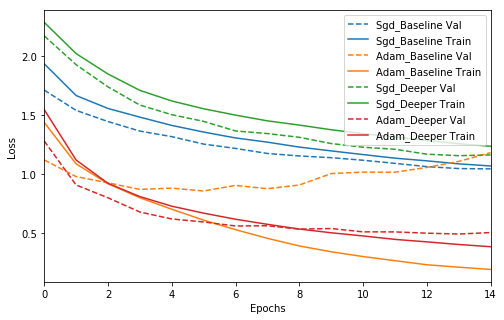

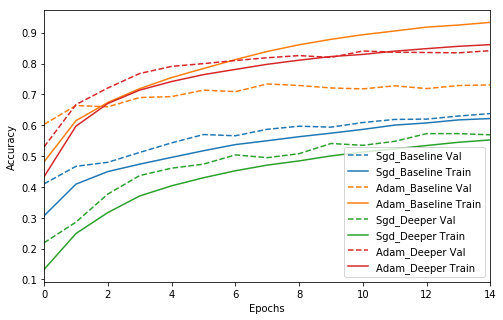

In [23]:
plot_loss_history([
    ('sgd_baseline', sgd_baseline_history),
    ('adam_baseline', adam_baseline_history),
    ('sgd_deeper', sgd_deeper_history),
    ('adam_deeper', adam_deeper_history)
])
plot_accuracy_history([
    ('sgd_baseline', sgd_baseline_history),
    ('adam_baseline', adam_baseline_history),
    ('sgd_deeper', sgd_deeper_history),
    ('adam_deeper', adam_deeper_history)
])

#### Image Augmentation

In [17]:
# set up image augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
)
datagen.fit(x_train)

In [18]:
lrate = 5e-4
epochs = 100
bsize = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=lrate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
baseline_history = model.fit(x_train, y_train, epochs=epochs, batch_size=bsize, validation_data=(x_val, y_val))

# train with image augmentation
# adam_aug_history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=bsize), steps_per_epoch = len(x_train) / bsize, epochs=epochs, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 16, 64)        256       
__________

TypeError: Unexpected keyword argument passed to optimizer: learning_rate

In [9]:
lrate = 5e-4
epochs = 100
bsize = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=lrate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# baseline_history = model.fit(x_train, y_train, epochs=epochs, batch_size=bsize, validation_data=(x_val, y_val))

# train with image augmentation
augmentation_history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=bsize), steps_per_epoch = len(x_train) / bsize, epochs=epochs, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 64)        256       
__________

TypeError: Unexpected keyword argument passed to optimizer: learning_rate

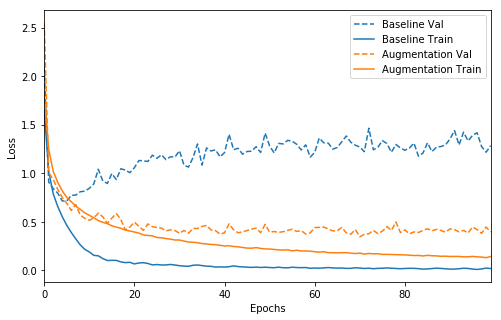

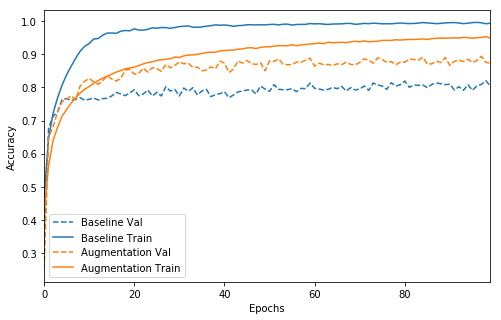

In [28]:
plot_loss_history([
    ('baseline', baseline_history),
    ('augmentation', augmentation_history)
])
plot_accuracy_history([
    ('baseline', baseline_history),
    ('augmentation', augmentation_history)
])

In [31]:
result = model.evaluate(x_test,y_test,batch_size=128)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [32]:
print("evaluate result: ", result)

evaluate result:  [0.4046127504348755, 0.8874]
